# Poincaré's bread

Allen Downey

[MIT License](https://en.wikipedia.org/wiki/MIT_License)

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot

decorate = thinkplot.config

## Poincaré's bread

Henri Poincaré was a French mathematician who taught at the Sorbonne around 1900.The following anecdote about him is probably fabricated, but it makes an interesting probability problem.

Supposedly, Poincaré suspected that his local bakery was selling loaves of bread that were lighter than the advertised weight of 1 kg, so every day for a year he bought a loaf of bread, brought it home and weighed it. At the end of the year, he plotted the distribution of his measurements and showed that it fit a normal distribution with mean 950 g and standard deviation 50 g. He brought this evidence to the bread police, who gave the baker a warning.

For the next year, Poincaré continued the practice of weighing his bread every day. At the end of the year, he found that the average weight was 1,000 g, just as it should be, but again he complained to the bread police, and this time they fined the baker.

Why? Because the shape of the distribution was asymmetric. Unlike the normal distribution, it was skewed to the right, which is consistent with the hypothesis that the baker was still making 950 g loaves, but deliberately giving Poincaré the heavier ones.

Write a program that simulates a baker who chooses `n` loaves from a distribution with mean 950 g and standard deviation 50 g, and gives the heaviest one to Poincaré. What value of `n` yields a distribution with mean 1000 g? What is the standard deviation?

Compare this distribution to a normal distribution with the same mean and the same standard deviation. Is the difference in the shape of the distribution big enough to convince the bread police?

First, I'll make a function that simulates choosing `n` loaves and giving Poincaré the heaviest.

In [2]:
def choose_bread(mean, std, n):
    loaves = np.random.normal(mean, std, size=n)
    return max(loaves)

In [3]:
mean = 950
std = 50
n = 5

choose_bread(mean, std, n)

1011.6471820193731

Here's a sample from the distribution of bread weight if the baker chooses 5 loaves.

In [4]:
sample = [choose_bread(mean, std, n) for i in range(10000)]
np.mean(sample)

1007.8192439398472

And here's how the observed mean depends on `n`.

In [5]:
for n in range(1, 10):
    sample = [choose_bread(mean, std, n) for i in range(10000)]
    print(n, np.mean(sample))

1 951.7199999769308
2 977.7487378819443
3 992.7060790163287
4 1000.9890242914458
5 1007.8572906549394
6 1013.4308434503292
7 1017.6831819356526
8 1021.1121654019436
9 1024.3022693139044


Looks like `n=4` yields a measured mean close to 1000 g.

Here's a large sample of bread weights with `n=4` so we can estimate the mean and standard deviation.

In [6]:
n = 4
sample = [choose_bread(mean, std, n) for i in range(10000)]

mu = np.mean(sample)
sigma = np.std(sample)
mu, sigma

(1001.1926451559488, 35.148730095698774)

Now let's compare the distribution of the sample to the normal distribution with the same mean and std.

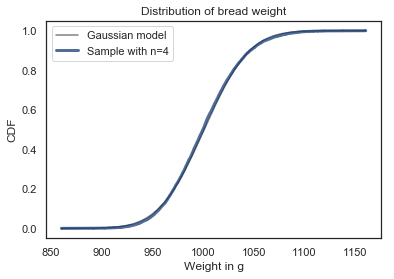

In [7]:
from scipy.stats import norm
xs = sample.copy()
xs.sort()
ys = norm.cdf(xs, mu, sigma)

plt.plot(xs, ys, color='gray', label='Gaussian model')
cdf = Cdf(sample, label='Sample with n=4')
thinkplot.Plot(cdf)
decorate(xlabel='Weight in g', ylabel='CDF', title='Distribution of bread weight')

Visually they are almost indistinguishable, which makes it seem unlikely that Poincaré could really tell the difference, especially with only 365 observations.

But let's look more closely.  First, let's simulate one year.

In [8]:
def simulate_year(mean, std, n, days):
    sample = [choose_bread(mean, std, n) for i in range(days)]
    return sample

As a test statistic, we'll use the sample skew.

In [9]:
from scipy.stats import skew

def test_stat(sample):
    return skew(sample)

The null hypothesis is that the data come from a normal distribution with the observed mean and standard deviation.

In [10]:
def run_model(mu, sigma, days):
    return np.random.normal(mu, sigma, size=days)

Now we can generate fake data under the null hypothesis and compute the test statistic.

In [11]:
test_stat(run_model(mu, sigma, 365))

0.038131358570070745

And we can estimate the distribution of the test statistic under the null hypothesis:

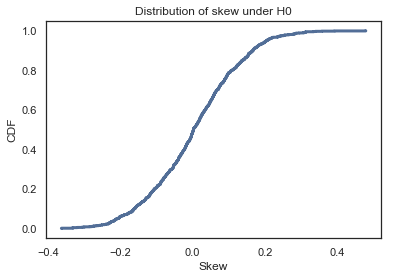

In [12]:
skew_under_null = [test_stat(run_model(mu, sigma, 365)) for i in range(1000)]
cdf = Cdf(skew_under_null)
thinkplot.Cdf(cdf)
decorate(xlabel='Skew', ylabel='CDF', title='Distribution of skew under H0')

Here's the 95th percentile of the test statistic under the null hypothesis.

In [13]:
thresh = np.percentile(skew_under_null, 95)
thresh

0.204601069269994

If Herni observes a skew above this threshold, he would conclude that it is statistically significant.

Let's see how often that would happen under the alternate hypothesis, that they baker is giving him the heaviest of 4 loaves.

In [14]:
n = 4
skew_poincare = [test_stat(simulate_year(mean, std, n, 365)) for i in range(1000)]

Here's what the sampling distribution looks like for the skew Poincaré observes.

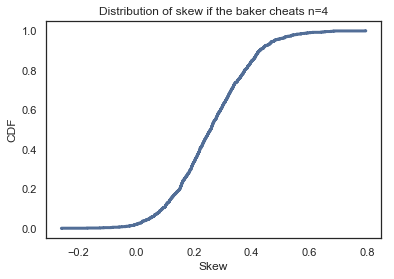

In [15]:
cdf = Cdf(skew_poincare)
thinkplot.Cdf(cdf)
decorate(xlabel='Skew', ylabel='CDF', title='Distribution of skew if the baker cheats n=4')

If Poincaré runs this experiment for a year, what is the chance he gets a statistically significant result?

In [16]:
np.mean(skew_poincare > thresh)

0.65

This probability is the power of the test.  In this example, it is 60-70%, which is not terrible.  As a very general guideline, statisticians recommend designing experiments with a power of about 80%.

For how many days would Poincaré have to weigh his bread to get a power of 80%?